In [2]:
%pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


🧩 1. Könyvtárak betöltése és fájlok beolvasása
python
Másolás
Szerkesztés


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3 CSV beolvasása
df_sort = pd.read_csv("1_sort/trajectory_data_sort.csv")
df_deep = pd.read_csv("2_deepsort/trajectory_data_deepsort.csv")
df_yolo = pd.read_csv("3_yolov8/trajectory_data_yolov8.csv")

# Hozzáadjuk a forrást minden dataframe-hez
df_sort["method"] = "SORT"
df_deep["method"] = "Deep SORT"
df_yolo["method"] = "YOLOv8"

# Egyesítés
df_all = pd.concat([df_sort, df_deep, df_yolo], ignore_index=True)


📈 2. Objektumszám vizsgálata
python
Másolás
Szerkesztés


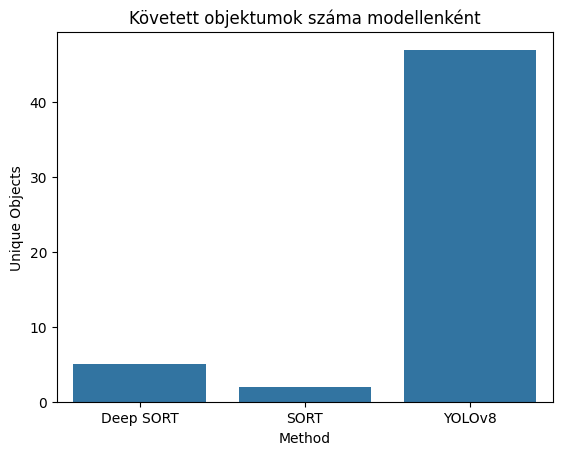

In [8]:
object_counts = df_all.groupby("method")["id"].nunique().reset_index()
object_counts.columns = ["Method", "Unique Objects"]
sns.barplot(data=object_counts, x="Method", y="Unique Objects")
plt.title("Követett objektumok száma modellenként")
plt.show()


🕵️‍♂️ 3. ID-váltások becslése (instabil követés)


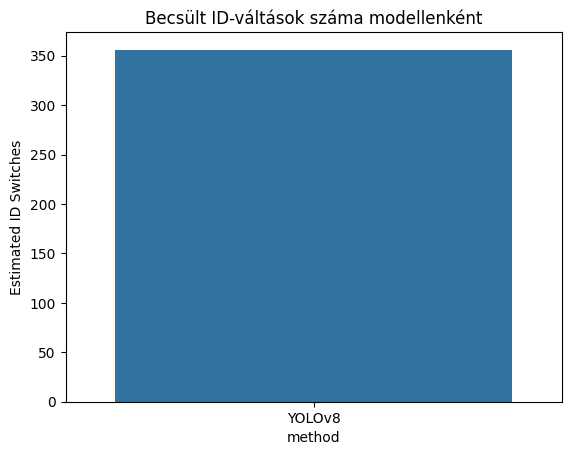

In [9]:
# Kerekített középpont pozíció alapján ID váltások becslése
df_all["x_center"] = ((df_all["x1"] + df_all["x2"]) / 2).round(-1)
df_all["y_center"] = ((df_all["y1"] + df_all["y2"]) / 2).round(-1)

# Hány ID váltás történt közel azonos helyeken
id_switch_estimate = df_all.groupby(["method", "x_center", "y_center"])["id"].nunique().reset_index()
id_switch_estimate = id_switch_estimate[id_switch_estimate["id"] > 1]

switch_counts = id_switch_estimate.groupby("method").size().reset_index(name="Estimated ID Switches")

sns.barplot(data=switch_counts, x="method", y="Estimated ID Switches")
plt.title("Becsült ID-váltások száma modellenként")
plt.show()


In [ ]:
📐 4. Pályahossz geometriai elemzése (objektumonként)
python
Másolás
Szerkesztés


C:\Users\HP\AppData\Local\Temp\ipykernel_423232\1747472820.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_lengths = df_all.groupby(["method", "id"]).apply(compute_path_length).reset_index(name="path_length")


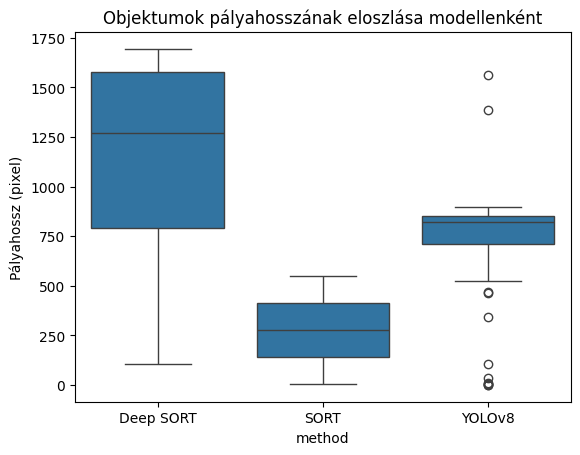

In [10]:
# Hozzáadjuk a középpontokat
df_all["x_center"] = (df_all["x1"] + df_all["x2"]) / 2
df_all["y_center"] = (df_all["y1"] + df_all["y2"]) / 2

# Pályahossz számítás objektumonként
def compute_path_length(group):
    return ((group["x_center"].diff()**2 + group["y_center"].diff()**2)**0.5).sum()

path_lengths = df_all.groupby(["method", "id"]).apply(compute_path_length).reset_index(name="path_length")

sns.boxplot(data=path_lengths, x="method", y="path_length")
plt.title("Objektumok pályahosszának eloszlása modellenként")
plt.ylabel("Pályahossz (pixel)")
plt.show()


In [ ]:
🔁 5. Átlagos pályahossz és keretenkénti ID-sűrűség
python
Másolás
Szerkesztés


Átlagos pályahossz:
method
Deep SORT    1087.035828
SORT          276.843462
YOLOv8        700.423496
Name: path_length, dtype: float64


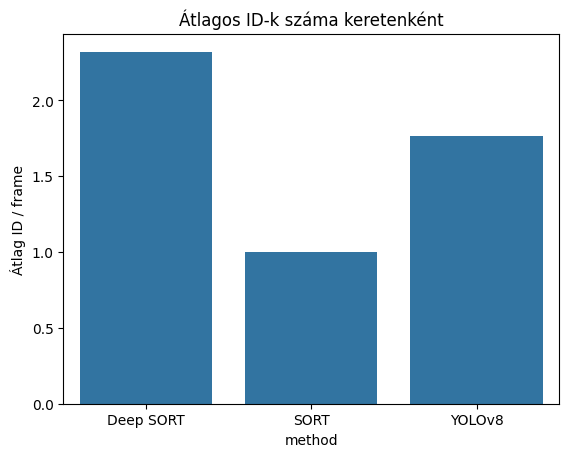

In [11]:
# Átlagos pályahossz
print("Átlagos pályahossz:")
print(path_lengths.groupby("method")["path_length"].mean())

# Átlagos ID-k száma egy frame-en
frame_stats = df_all.groupby(["method", "frame"])["id"].nunique().reset_index(name="objects_per_frame")
frame_avg = frame_stats.groupby("method")["objects_per_frame"].mean().reset_index()

sns.barplot(data=frame_avg, x="method", y="objects_per_frame")
plt.title("Átlagos ID-k száma keretenként")
plt.ylabel("Átlag ID / frame")
plt.show()
